In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report,f1_score
from sklearn.metrics import confusion_matrix

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline

### Dataset Load

In [2]:
data = pd.read_csv('data/conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


### Data Quality Check

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
for column in data.columns:
    uni_val = sorted(data[column].unique())
    print('{0:18s} {1:6d}\t'.format(column, len(uni_val)), uni_val[:10])

country                 4	 ['China', 'Germany', 'UK', 'US']
age                    60	 [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
new_user                2	 [0, 1]
source                  3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
converted               2	 [0, 1]


### Outlier Check

In [6]:
data[data['age'] > 100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [7]:
# It's unreasonable that people age is more than 100 is it a logging issue???
data = data[data['age'] < 100]

### Exploratory Data Analysis

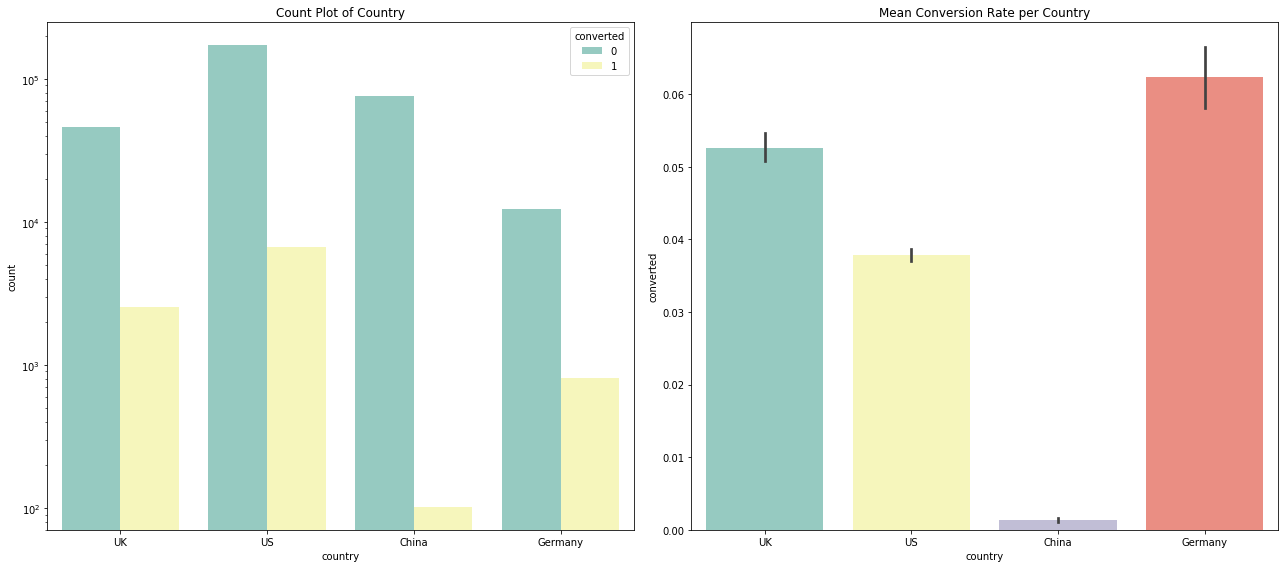

In [8]:
# Visualization of different countries
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.countplot(x='country', hue='converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of Country', fontsize=12)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean Conversion Rate per Country', fontsize=12)
plt.tight_layout()
plt.show()

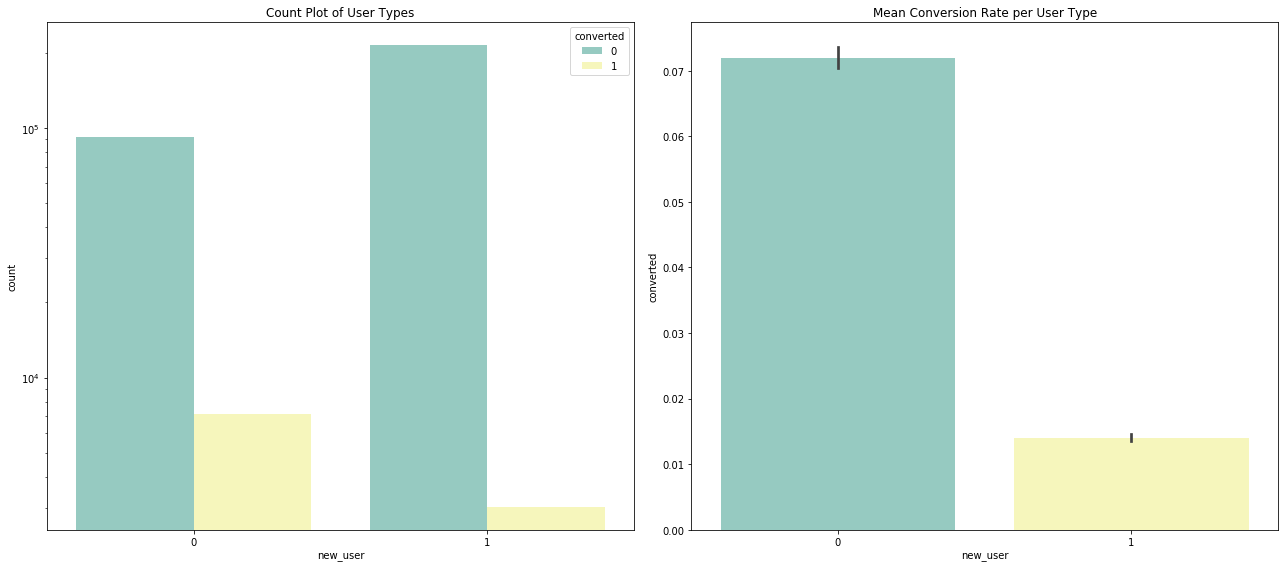

In [9]:
# Visualization of different user types
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of User Types', fontsize=12)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=12)
plt.tight_layout()
plt.show()

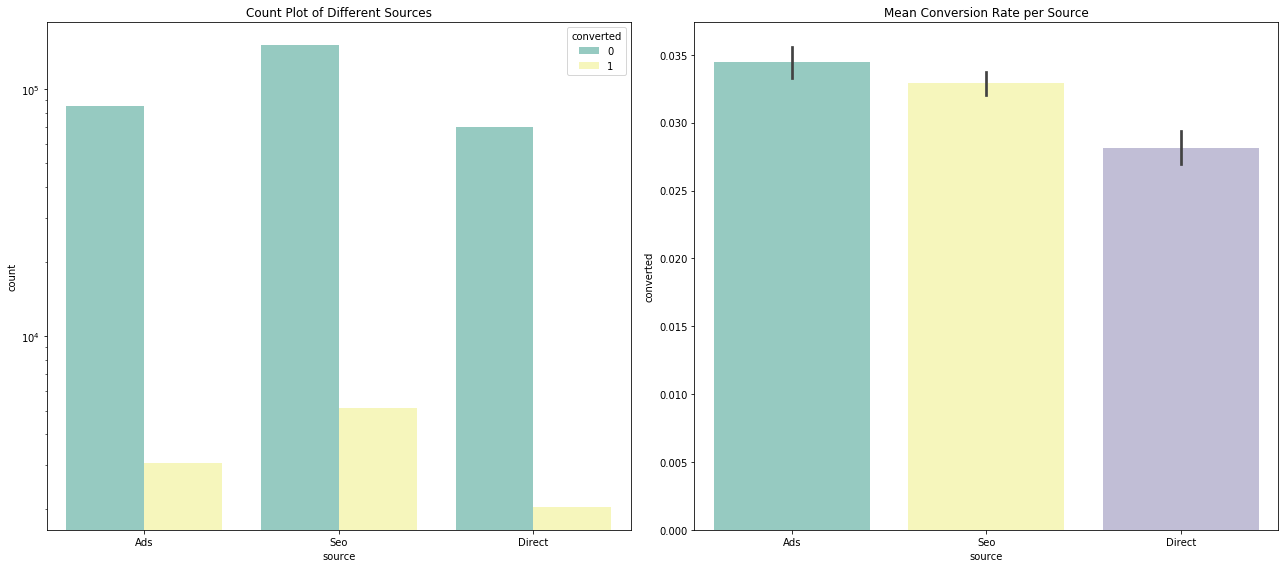

In [10]:
# Visualization of different sources
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of Different Sources', fontsize=12)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean Conversion Rate per Source', fontsize=12)
plt.tight_layout()
plt.show()

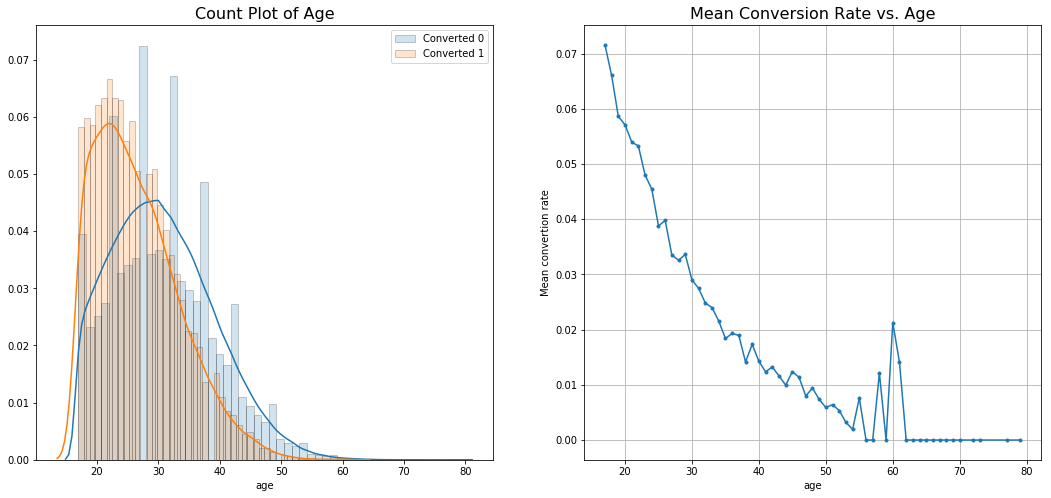

In [11]:
# Visualization of different age
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

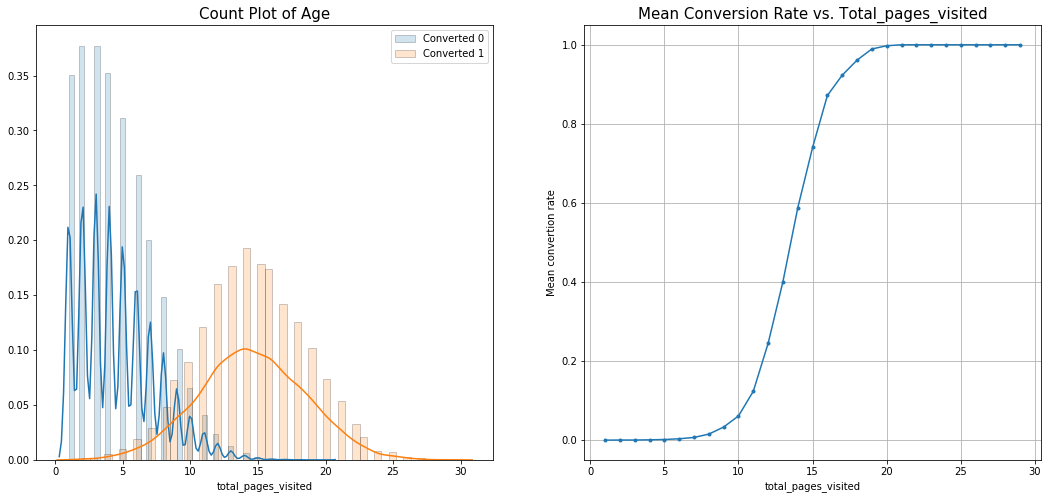

In [12]:
# Visualization of different total pages
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=15)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=15)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()


### ML Model Build

In [13]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,8 mins 01 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,5 months and 4 days !!!
H2O cluster name:,H2O_from_python_dwightliu_k09dkb
H2O cluster total nodes:,1
H2O cluster free memory:,3.300 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [14]:
# Transform to H2O Frame, and make sure the target variable is categorical
df = H2OFrame(data)
df['converted'] = df['converted'].asfactor()
df['new_user'] = df['new_user'].asfactor()
df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.56931100133461,,,4.872918234777001,
maxs,,79.0,,,29.0,
sigma,,8.268957596421435,,,3.3410533442156285,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [15]:
# Split into 80% training and 20% test dataset
strat_split = df['converted'].stratified_split(test_frac=0.2, seed=1)

train = df[strat_split == 'train']
test = df[strat_split == 'test']
feature = list(data.drop('converted',axis=1).columns)
target = 'converted'

In [16]:
feature

['country', 'age', 'new_user', 'source', 'total_pages_visited']

In [17]:
# Build random forest model
rf = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, 
                                seed=1, score_each_iteration=True)
rf.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


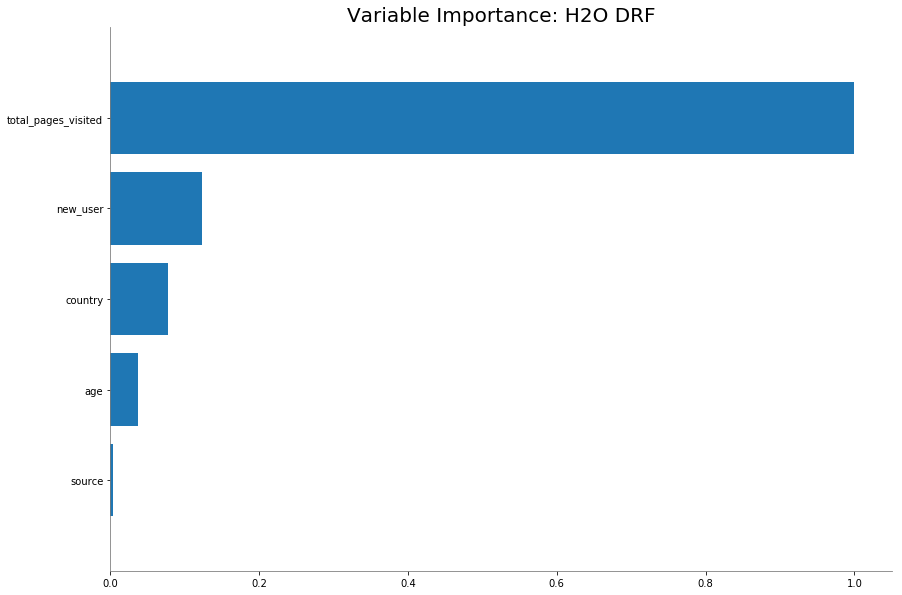

In [18]:
rf.varimp_plot()

In [19]:
# Make predictions
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = rf.predict(train).as_data_frame()['p1'].values
test_pred = rf.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [20]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61200
           1       0.86      0.65      0.74      2040

   micro avg       0.99      0.99      0.99     63240
   macro avg       0.93      0.83      0.87     63240
weighted avg       0.98      0.99      0.98     63240



Text(0.5,1,'f1_score Score: 0.7439398161047646')

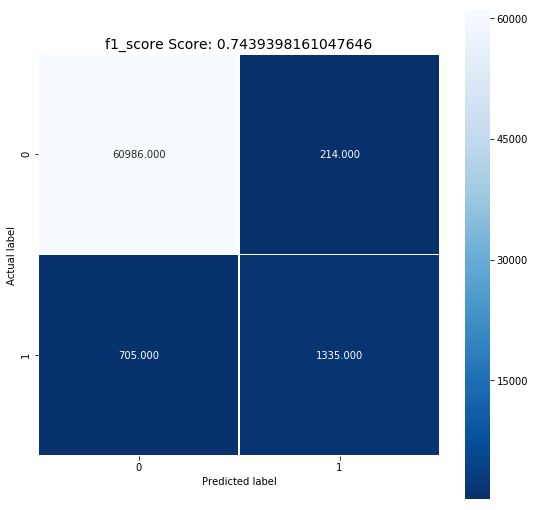

In [21]:
cm = confusion_matrix(test_true, (test_pred > 0.5).astype(int))
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'f1_score Score: {0}'.format(f1_score( test_true, (test_pred > 0.5).astype(int)))
plt.title(all_sample_title, size = 14)

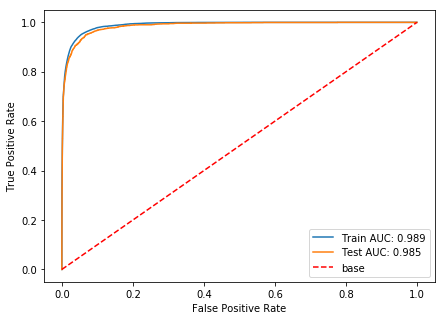

In [22]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
plt.plot([0, 1], [0, 1], 'r--',label='base')
ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
ax.legend(fontsize=10)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


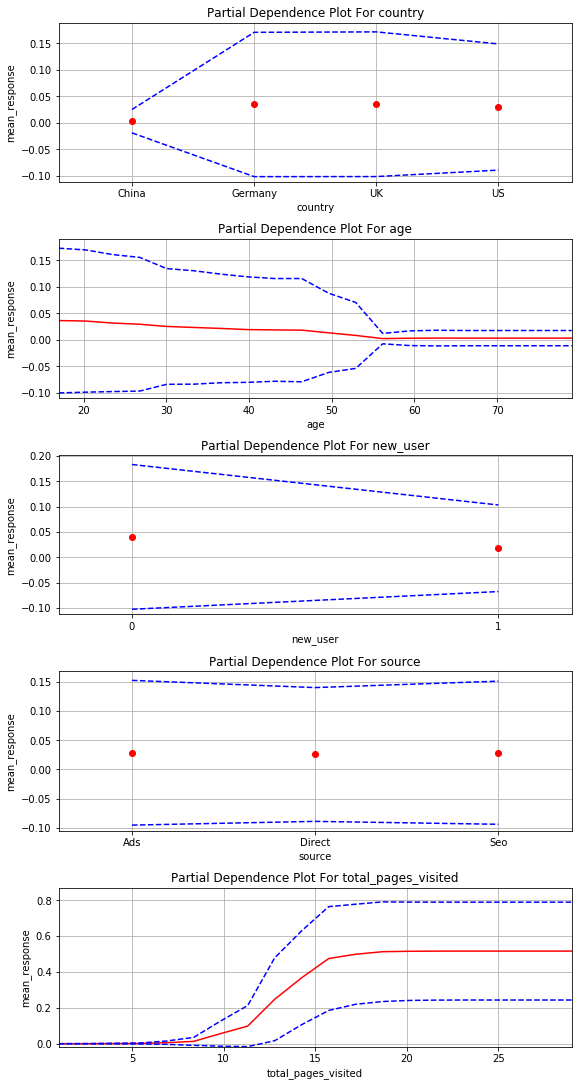

In [23]:
_ = rf.partial_plot(train, cols=feature, figsize=(8, 15))

In [24]:
h2o.cluster().shutdown()

H2O session _sid_8ddb closed.


### Question 1: 

Here I use random forest to predict conversion rate because 
it usually needs very little time to optimize it and it is strong with outliers, 
irrelevant features, continuous and discrete variables,and handle nonlinear relation. 
I will use its partial dependence plots and variable importance to get insights 
about how it got information from the features.


### Question 2:

1.'total_pages_visited'
2.'new_user'
3.'country'
4.'age'
5.'source'


### Question 3:


1 'total_pages_visited' . If someone people has visited many pages, but haven’t converted, they should have high possibility to convert. I will tell makreting team to target at these people probably send eamils to them. They are probably the easiest users to make convert. 

2.'new_user'. return users convert more . I will tell makreting team to target them and send email with promoce code to bring them back to the site. New user convert less, Is there any problem with the sign up or transaction process, I will tell the product team whehter we can developnew feature for new user to sign up or registered like one-click process.

3.'country'. The site performans well for Germany in terms of conversion. 
But in the EDA it showed that there are few Germans coming to the site: less than other countries, despite it's big country. I will tell marketing team to recruit Germans or promote more in German. The site performans worse for Chinese, I will ask the product team is there any issue like translation, cultural fit, or foriegn transaction.
There are many chinese user visits but less convert, the issue really needs to be fixed.

4.'age'. The site works very well for young users. I will tell marketing team to reach to young people and advertise more. Why older users perform so poorly? From 27 years old conversion clearly starts dropping.

5.'source', Ads works well, I will tell makreting team to invest more money in Ads.
Why direct works not that well compare to others, They have high intent to come to the site, I will ask the product team how the recommendation or personalization systems can be improved.


### Question 4:

There are many missing key information.

1.What's the baseline conversion of holdout of each group, are they the same?

2.Even the holdout conversion rate of each group are close, I still need to know.
eg there is incremental conversion rate 2.5%, is it from 2.5% to 5.0% or 25% to 27.5%?

3.Assumed that it's a the “Uber for Scooters” service, the user are connected, how 
the experiment split the user, I suggest this experiemtn run by market because control 
and treatment group should be isolated. If control and treatment group users are in the same 
cities or area,  this experiment will fail.

4.How long does the experiment run? is it well distributed all over at least one week that fully captured user weekly behavior pattern? Some experiment temporary result even turn statistical significant just over holiday back back to not significant later.

5.Is there any visual change? We need to watch out for the novelty effect. We need to split the user into new user and return user. new user will not be affect by the novelty effect



### Question 5:

There are two main tastks:
1.data quality check,cleaning and preparation
2.model training and tuning

in the production phase,

1.we need a data pipeline for data quality check (validation) , duplicate check
above step can help us know whether there is any logging issue.

2.data feature engineering,selection, and scailing.
This can be achieved by EDA (needs some doamin knowledge)
or programming way like recursive feature elimination

3.model traing using cross validation and tuning using GridSearch, sometimes plus 
  cost matrix (TP,TN,FP,FN) to adjust the threshould.

4.Visualize the model,
    feature importance plot, partial dependency plot, or sometimes decision tree plot.
    choose top 10 feature to plot the feature VS target variable.
